[View in Colaboratory](https://colab.research.google.com/github/workpiles/soybeans_sorter/blob/master/soybeans_sorter.ipynb)

# 環境構築

### GPU&バージョン確認

GPUインスタンスに接続できているかを確認します．“GPUゲットだぜ！”と表示されれば問題ありません．

ゲットできなかった場合でも，CPUを使って実験を進めることは可能ですが，学習にとても時間がかかります．ゲットできなかった場合は，しばらく時間を置いてから再度接続を試してみて下さい．

In [1]:
import tensorflow as tf
import keras

if tf.test.gpu_device_name() == "/device:GPU:0":
  print("GPUゲットだぜ！")
else:
  print("逃した…")

print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)

Using TensorFlow backend.


GPUゲットだぜ！
TensorFlow: 1.10.1
Keras: 2.1.6


### 必要パッケージのインポート

最初に使用するパッケージのインポートを行います．

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Activation, Reshape, concatenate, Dropout, Flatten
from keras.layers import BatchNormalization, MaxPooling2D
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.decomposition import PCA
import time


### データセット取得

枝豆データセットをダウンロードして，使いやすようにデータを変換しておきます．

画像データは255で割ることにより値が0.0-1.0に収まるように変換します．

ラベルデータは，One-Hot形式に変換します．


Redirecting output to ‘wget-log.1’.
(600, 48, 64, 1) (600, 2) (580, 48, 64, 1) (580, 2)


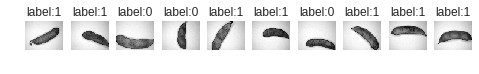

In [4]:
#ダウンロード
!wget "https://github.com/workpiles/soybeans_sorter/raw/master/soybeans_gray.npz" -O soybeans_dataset.npz -q

#ダウンロードしたデータセットの読み込み
IMAGE_HEIGHT = 48
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 1
CLASSES = 2
def load_data():
  data = np.load("soybeans_dataset.npz")
  x_train = data['x_train'].astype('float32') / 255.
  x_test  = data['x_test'].astype('float32') / 255.
  x_train = x_train.reshape([-1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
  x_test  = x_test.reshape([-1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
  y_train = np.eye(CLASSES)[data['y_train']]
  y_test  = np.eye(CLASSES)[data['y_test']]
  return x_train, y_train, x_test, y_test

X_train, y_train, X_test, y_test = load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#画像の確認
fig, ax = plt.subplots(1, 10)
for i in range(10):
  if IMAGE_CHANNEL == 1:
    ax[i].imshow(X_train[np.random.randint(len(X_train))].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
  else:
    ax[i].imshow(X_train[np.random.randint(len(X_train))])
  ax[i].axis('off')
  ax[i].set_title("label:%d"%(np.argmax(y_train[i])))
plt.show()


# Conditional GANを使ったデータ作り実験

### Generatorの構築

In [0]:
def build_generator():
  noize_input = Input(shape=[100]) #入力は100次元の潜在変数
  cond_input = Input(shape=[CLASSES])    #とラベル
  model_input = concatenate([noize_input, cond_input], axis=1)
  x = Dense(256*6*8, kernel_initializer=RandomNormal(stddev=0.02))(model_input) #102->256*6*8
  x = BatchNormalization(momentum=0.8)(x)
  x = Activation('relu')(x)
  x = Reshape([6, 8, 256])(x) #256*6*8-> 6x8x256
  x = UpSampling2D()(x) #6x8x256->12x16x256
  x = Conv2D(128, kernel_size=5, padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x) #12x16x256->12x16x128
  x = BatchNormalization(momentum=0.8)(x)
  x = Activation('relu')(x)  
  x = UpSampling2D()(x) #12x16x128->24x32x128
  x = Conv2D(64, kernel_size=3, padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x) #24x32x128->24x32x64
  x = BatchNormalization(momentum=0.8)(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x) #24x32x64->48x64x64
  x = Conv2D(32, kernel_size=3, padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x) #48x64x64->48x64x32
  x = BatchNormalization(momentum=0.8)(x)
  x = Activation('relu')(x)
  x = Conv2D(IMAGE_CHANNEL, kernel_size=3, padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x) #48x64x32->48x64x1
  model_output = Activation('sigmoid')(x)
  
  model = Model([noize_input, cond_input], model_output)
  return model

### Discriminatorの構築

In [0]:
def build_discriminator():
  image_input = Input(shape=[IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL]) #入力は画像
  cond_input = Input(shape=[CLASSES])                                 #とラベル
  cond_ = Reshape([1, 1, CLASSES])(cond_input)
  cond_ = UpSampling2D(size=(IMAGE_HEIGHT, IMAGE_WIDTH))(cond_)
  model_input = concatenate([image_input, cond_], axis=-1) #画像とラベルを連結 shape=48x64x3
  x = Conv2D(32, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=0.02))(model_input) #48x64x3->24x32x32
  x = LeakyReLU(0.2)(x)
  x = Dropout(0.25)(x)
  x = Conv2D(64, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x) #24x32x32->12x16x64
  x = LeakyReLU(0.2)(x)
  x = Dropout(0.25)(x)
  x = Conv2D(128, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x) #12x16x64->6x8x128
  x = LeakyReLU(0.2)(x)
  x = Dropout(0.25)(x)
  x = Flatten()(x) #6x8x128->6*8*128
  x = Dense(256)(x) #6*8*128->256
  x = LeakyReLU(0.2)(x)
  x = Dropout(0.25)(x)
  model_output = Dense(2, activation='softmax')(x) #256->2
  
  model = Model([image_input, cond_input], model_output)
  return model

### 学習モデルの構築

In [0]:
#discriminatorの学習モデル
discriminator = build_discriminator()
discriminator.trainable = True
discriminator.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['acc'])

#generatorの学習モデル
generator = build_generator()
z = Input(shape=[100])
cond = Input(shape=[CLASSES])
gen_image = generator([z, cond])
discriminator.trainable = False
valid = discriminator([gen_image, cond])
combined_model = Model([z, cond], valid)
combined_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['acc'])

def train_gan(max_step=1000, batch_size=32):
  start = time.time()
  datagen = ImageDataGenerator(
    rotation_range=60,
    horizontal_flip=True,
    vertical_flip=True)

  for step in range(max_step):
    #--------------------
    # Discriminatorの学習
    #--------------------
    g = datagen.flow(X_train, y_train, batch_size=batch_size)
    images, labels = g.next()
    
    #バッチサイズ分のノイズから画像を生成する
    noize = np.random.uniform(0, 1, size=[batch_size, 100])
    generated_images = generator.predict([noize, labels])
    X = np.concatenate((images, generated_images))
    y = np.zeros([batch_size*2, 2])
    y[:batch_size, 1] = 1
    y[batch_size:, 0] = 1
    X_labels = np.concatenate((labels, labels))
    d_loss = discriminator.train_on_batch([X, X_labels], y)
    
    #----------------
    # Generatorの学習
    #----------------
    noize = np.random.uniform(0, 1, size=[batch_size, 100])
    g_loss = combined_model.train_on_batch([noize, labels], y[:batch_size,:])    

    if (step+1) % 1000 == 0:
      print("Step %d : g_acc=%f d_acc=%f"%(step+1, g_loss[1], d_loss[1]))
      results = generator.predict([noize, labels])
      fig, ax = plt.subplots(1, 10, figsize=(12,2))
      for i in range(10):
        if IMAGE_CHANNEL == 1:
          ax[i].imshow(results[i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
        else:
          ax[i].imshow(results[i])
        ax[i].axis('off')
        ax[i].set_title("label:%d"%(np.argmax(labels[i])))
      plt.show()
      print("Elapsed Time:%fs"%(time.time() - start))

  generator.save('generator.h5')
  discriminator.save('discrimitor.h5')
  combined_model.save('combined_model.h5')
  

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step 1000 : g_acc=0.281250 d_acc=0.710938


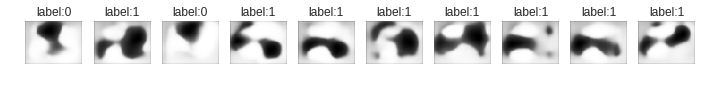

Elapsed Time:174.883663s
Step 2000 : g_acc=0.046875 d_acc=0.710938


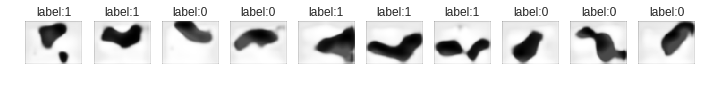

Elapsed Time:344.529917s
Step 3000 : g_acc=0.343750 d_acc=0.710938


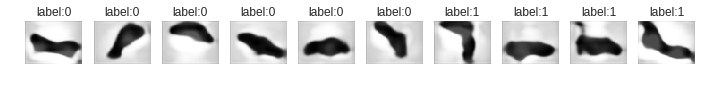

Elapsed Time:514.218422s
Step 4000 : g_acc=0.093750 d_acc=0.906250


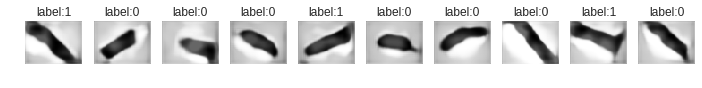

Elapsed Time:683.751071s
Step 5000 : g_acc=0.265625 d_acc=0.585938


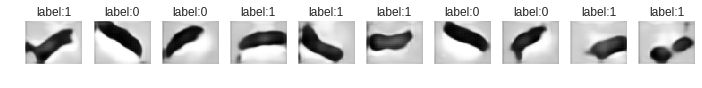

Elapsed Time:853.368823s
Step 6000 : g_acc=0.484375 d_acc=0.593750


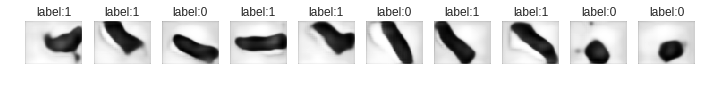

Elapsed Time:1022.810234s
Step 7000 : g_acc=0.281250 d_acc=0.718750


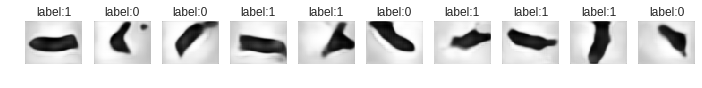

Elapsed Time:1191.905995s
Step 8000 : g_acc=0.515625 d_acc=0.687500


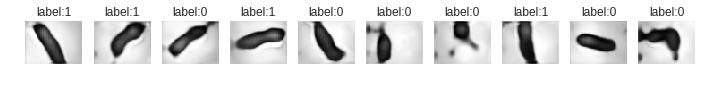

Elapsed Time:1361.075380s
Step 9000 : g_acc=0.343750 d_acc=0.625000


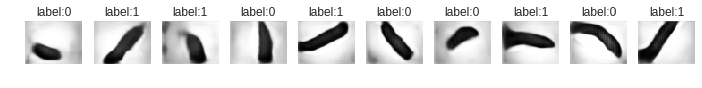

Elapsed Time:1530.081934s
Step 10000 : g_acc=0.218750 d_acc=0.750000


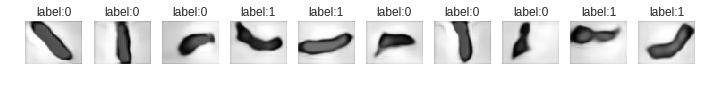

Elapsed Time:1699.079731s
Step 11000 : g_acc=0.515625 d_acc=0.531250


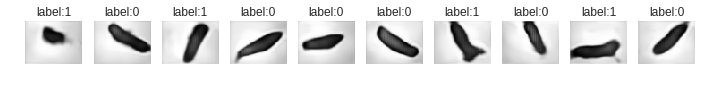

Elapsed Time:1868.091269s
Step 12000 : g_acc=0.218750 d_acc=0.648438


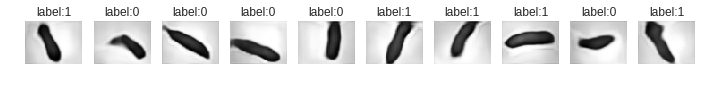

Elapsed Time:2037.258440s
Step 13000 : g_acc=0.375000 d_acc=0.656250


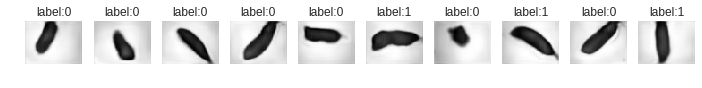

Elapsed Time:2207.008457s
Step 14000 : g_acc=0.187500 d_acc=0.648438


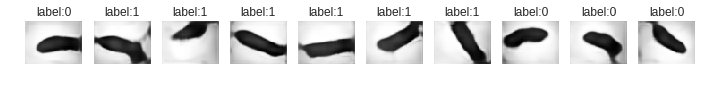

Elapsed Time:2376.891842s
Step 15000 : g_acc=0.828125 d_acc=0.382812


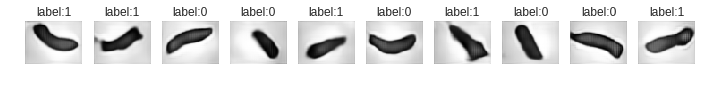

Elapsed Time:2546.086034s
Step 16000 : g_acc=0.328125 d_acc=0.695312


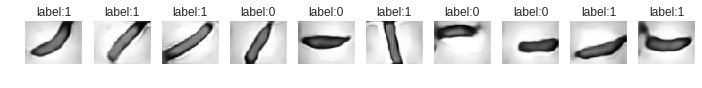

Elapsed Time:2715.589252s
Step 17000 : g_acc=0.343750 d_acc=0.648438


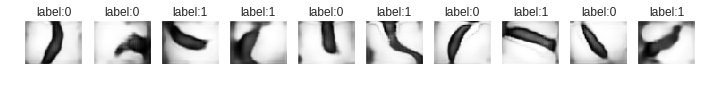

Elapsed Time:2885.123835s
Step 18000 : g_acc=0.031250 d_acc=0.765625


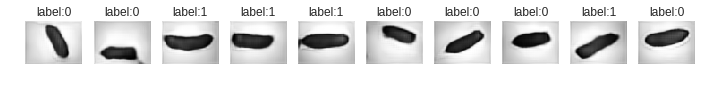

Elapsed Time:3054.418736s
Step 19000 : g_acc=0.140625 d_acc=0.648438


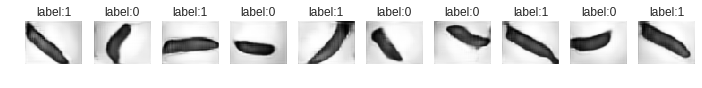

Elapsed Time:3223.906945s
Step 20000 : g_acc=0.265625 d_acc=0.656250


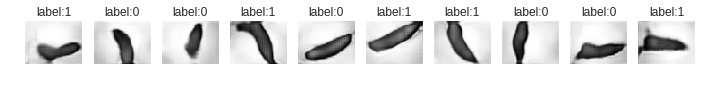

Elapsed Time:3393.488483s
Step 21000 : g_acc=0.437500 d_acc=0.578125


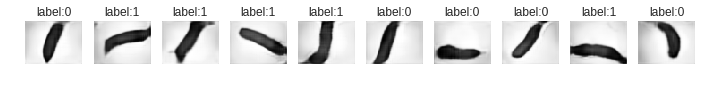

Elapsed Time:3562.753682s
Step 22000 : g_acc=0.375000 d_acc=0.671875


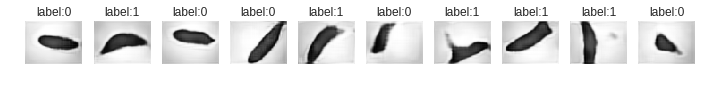

Elapsed Time:3732.304821s
Step 23000 : g_acc=0.312500 d_acc=0.718750


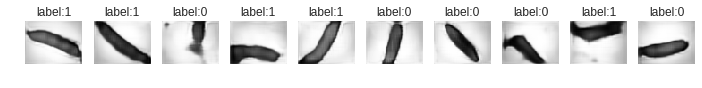

Elapsed Time:3902.050324s
Step 24000 : g_acc=0.453125 d_acc=0.609375


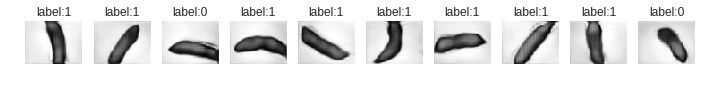

Elapsed Time:4071.566307s
Step 25000 : g_acc=0.203125 d_acc=0.828125


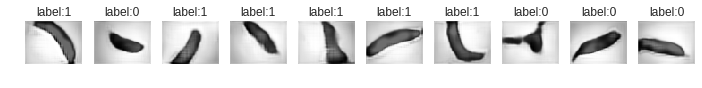

Elapsed Time:4241.215084s
Step 26000 : g_acc=0.250000 d_acc=0.656250


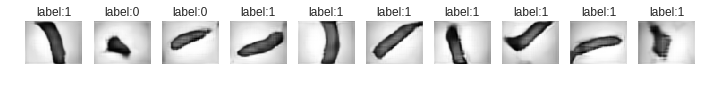

Elapsed Time:4410.986712s
Step 27000 : g_acc=0.140625 d_acc=0.750000


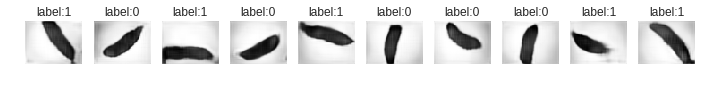

Elapsed Time:4580.597293s
Step 28000 : g_acc=0.390625 d_acc=0.679688


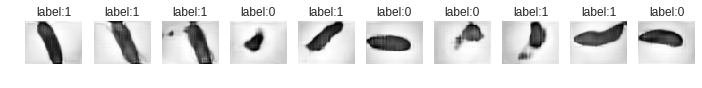

Elapsed Time:4750.103189s
Step 29000 : g_acc=0.593750 d_acc=0.656250


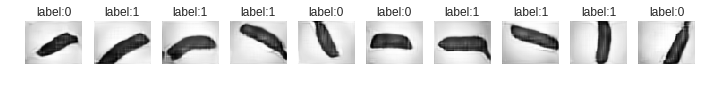

Elapsed Time:4919.667261s
Step 30000 : g_acc=0.250000 d_acc=0.625000


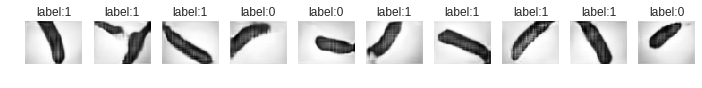

Elapsed Time:5089.552795s
Step 31000 : g_acc=0.250000 d_acc=0.687500


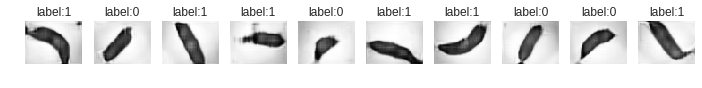

Elapsed Time:5259.418146s
Step 32000 : g_acc=0.484375 d_acc=0.617188


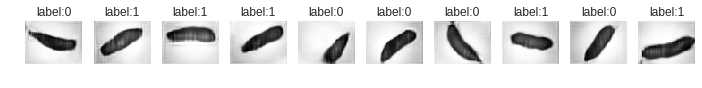

Elapsed Time:5429.172984s
Step 33000 : g_acc=0.218750 d_acc=0.773438


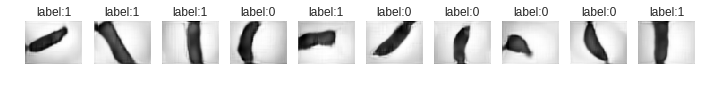

Elapsed Time:5598.667197s
Step 34000 : g_acc=0.125000 d_acc=0.632812


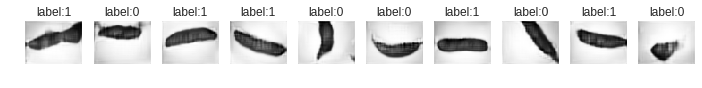

Elapsed Time:5768.023839s
Step 35000 : g_acc=0.312500 d_acc=0.781250


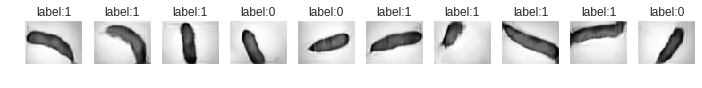

Elapsed Time:5937.259549s
Step 36000 : g_acc=0.390625 d_acc=0.679688


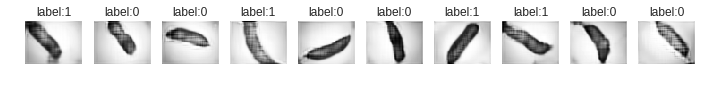

Elapsed Time:6106.499591s
Step 37000 : g_acc=0.500000 d_acc=0.648438


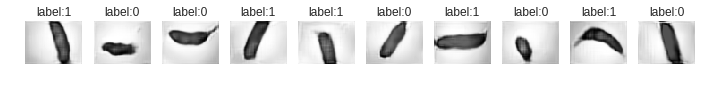

Elapsed Time:6275.678668s
Step 38000 : g_acc=0.171875 d_acc=0.710938


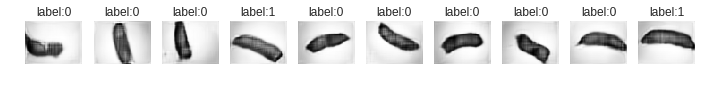

Elapsed Time:6445.001815s
Step 39000 : g_acc=0.609375 d_acc=0.609375


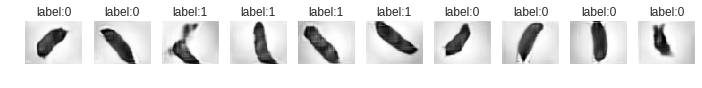

Elapsed Time:6613.615308s
Step 40000 : g_acc=0.156250 d_acc=0.750000


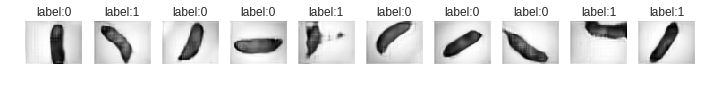

Elapsed Time:6782.252136s
Step 41000 : g_acc=0.500000 d_acc=0.648438


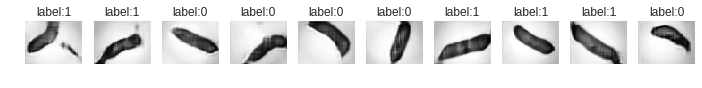

Elapsed Time:6950.913983s
Step 42000 : g_acc=0.437500 d_acc=0.656250


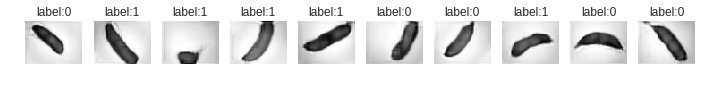

Elapsed Time:7119.365378s
Step 43000 : g_acc=0.375000 d_acc=0.593750


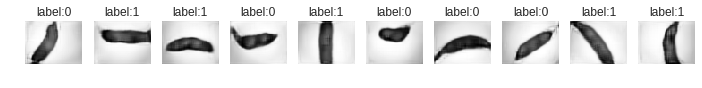

Elapsed Time:7288.246333s
Step 44000 : g_acc=0.531250 d_acc=0.593750


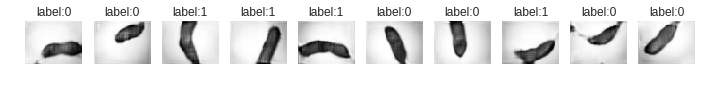

Elapsed Time:7456.869378s
Step 45000 : g_acc=0.687500 d_acc=0.585938


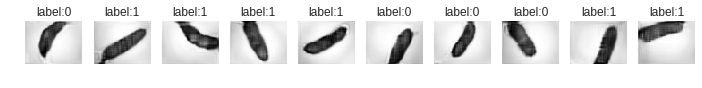

Elapsed Time:7625.261612s
Step 46000 : g_acc=0.453125 d_acc=0.648438


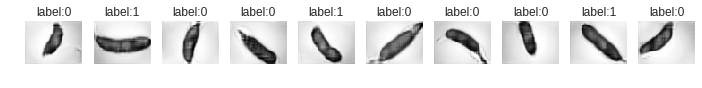

Elapsed Time:7793.026420s
Step 47000 : g_acc=0.453125 d_acc=0.593750


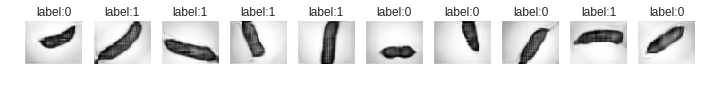

Elapsed Time:7960.441728s
Step 48000 : g_acc=0.343750 d_acc=0.562500


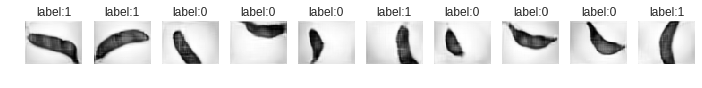

Elapsed Time:8128.014909s
Step 49000 : g_acc=0.406250 d_acc=0.632812


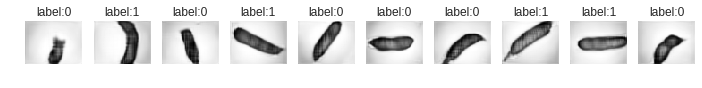

Elapsed Time:8296.164010s
Step 50000 : g_acc=0.203125 d_acc=0.757812


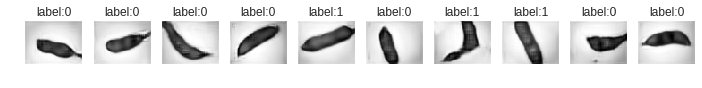

Elapsed Time:8464.362166s
Step 51000 : g_acc=0.609375 d_acc=0.546875


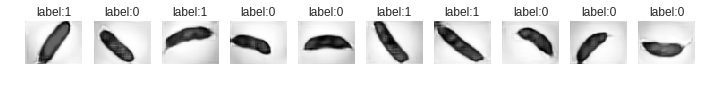

Elapsed Time:8633.359763s
Step 52000 : g_acc=0.343750 d_acc=0.632812


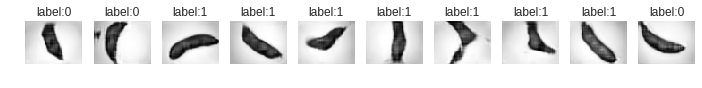

Elapsed Time:8802.045946s
Step 53000 : g_acc=0.515625 d_acc=0.539062


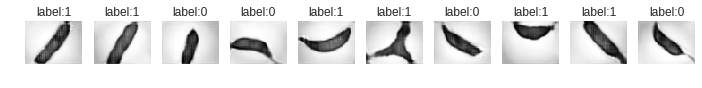

Elapsed Time:8970.667222s
Step 54000 : g_acc=0.421875 d_acc=0.585938


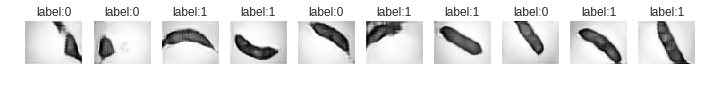

Elapsed Time:9139.791847s
Step 55000 : g_acc=0.203125 d_acc=0.757812


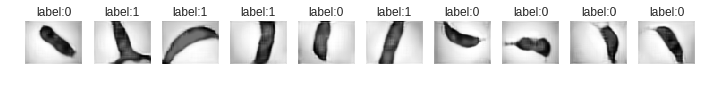

Elapsed Time:9308.753051s
Step 56000 : g_acc=0.421875 d_acc=0.750000


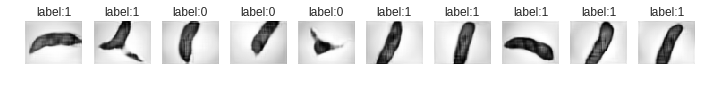

Elapsed Time:9477.500557s
Step 57000 : g_acc=0.343750 d_acc=0.625000


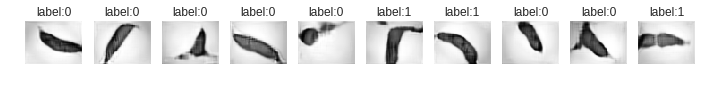

Elapsed Time:9646.345511s
Step 58000 : g_acc=0.281250 d_acc=0.687500


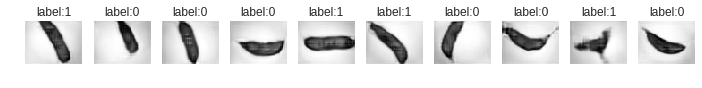

Elapsed Time:9815.844571s
Step 59000 : g_acc=0.328125 d_acc=0.640625


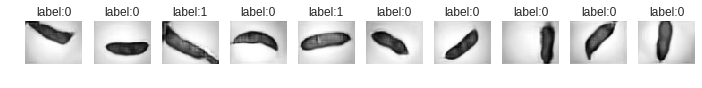

Elapsed Time:9984.394834s
Step 60000 : g_acc=0.250000 d_acc=0.804688


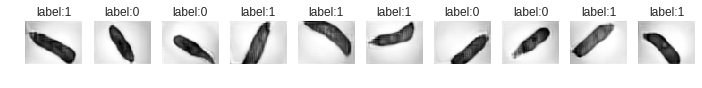

Elapsed Time:10153.296442s


In [9]:
#学習を実行する
train_gan(max_step=60000, batch_size=64)

### 生成した画像の確認

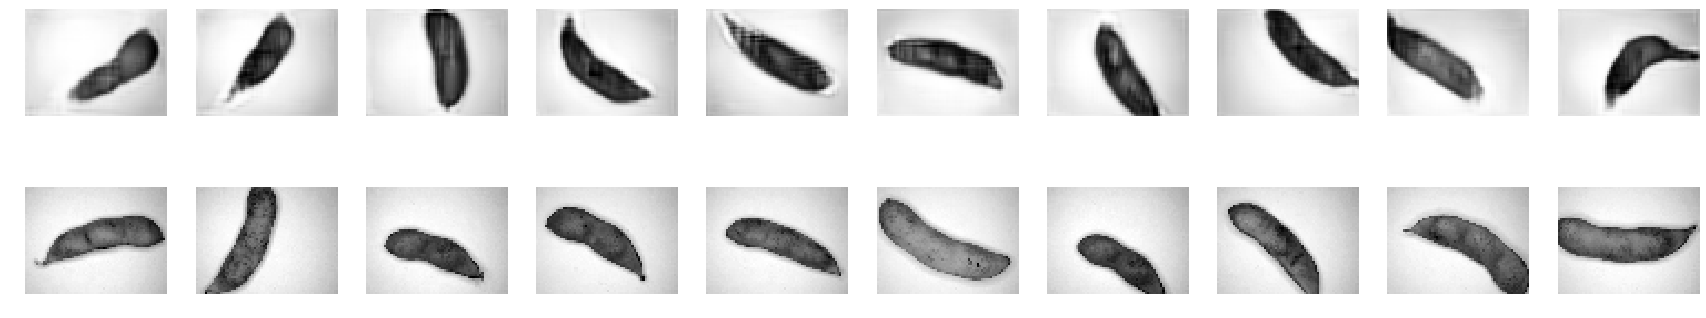

In [10]:
num = 10
cond = 0

noize = np.random.uniform(0, 1, size=[num, 100])
cond_ = np.tile(np.eye(CLASSES)[cond], (num,1))
generated_images = generator.predict([noize, cond_])

fig, ax = plt.subplots(2, num, figsize=(30,6))
for i in range(num):
  if IMAGE_CHANNEL == 1:
    ax[0,i].imshow(generated_images[i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
    ax[1,i].imshow(X_train[i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
  else:
    ax[0,i].imshow(generated_images[i])
    ax[1,i].imshow(X_train[i])
  ax[0,i].axis('off')
  ax[1,i].axis('off')

plt.show()

### 大量に作ってみる

LABEL 0


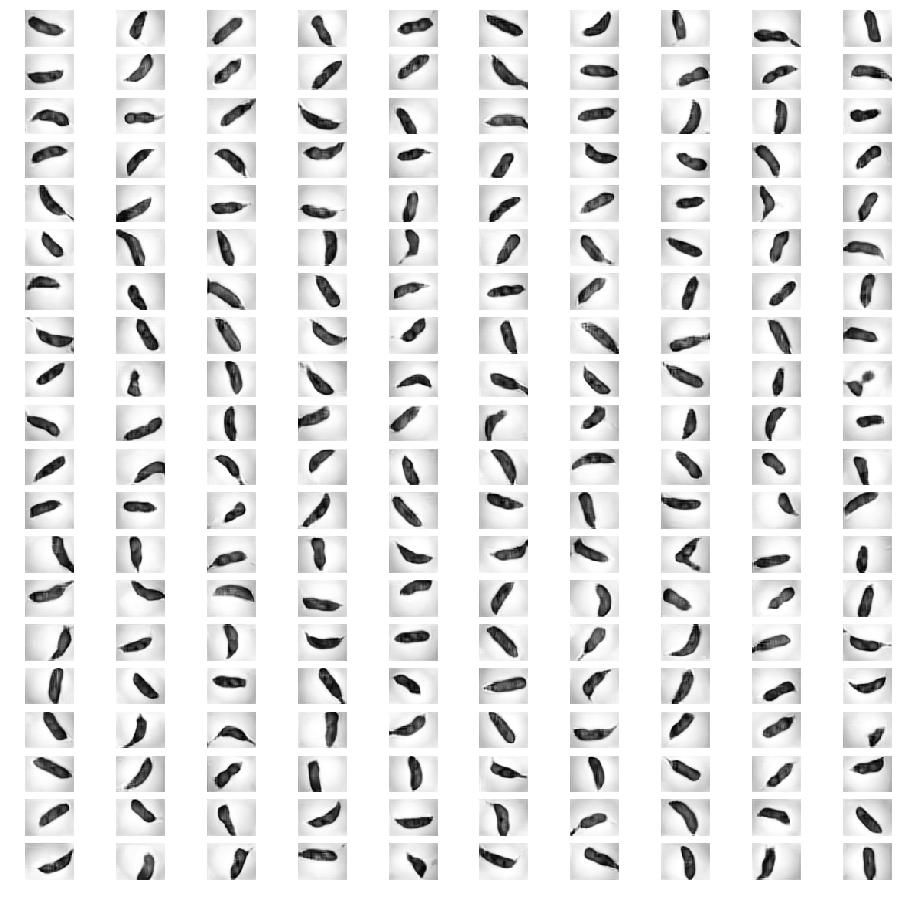

LABEL 1


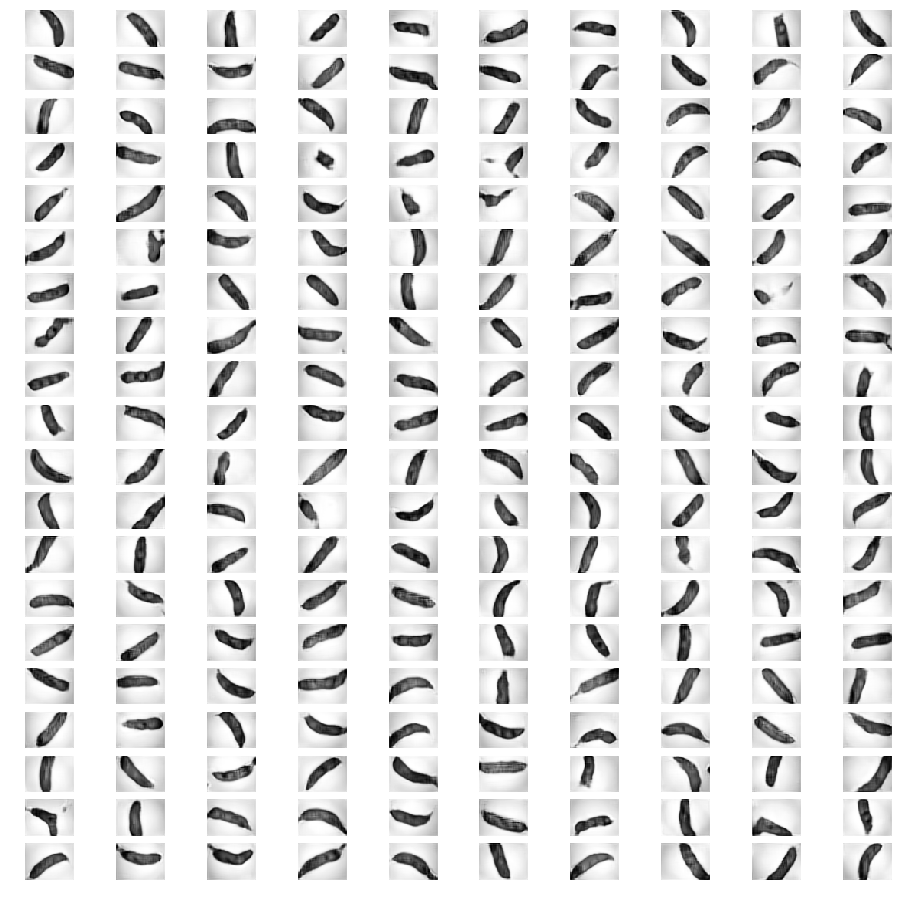

In [11]:
num = 200

for cond in range(CLASSES):
  cond_ = np.tile(np.eye(CLASSES)[cond], (num,1))
  noize = np.random.uniform(0, 1, size=[num, 100])
  generated_images = generator.predict([noize, cond_])

  print("LABEL %d"%(cond))
  fig, ax = plt.subplots(num//10, 10, figsize=(16, 16))
  for i in range(num//10):
    for j in range(10):
      if IMAGE_CHANNEL == 1:
        ax[i, j].imshow(generated_images[i*10+j].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
      else:
        ax[i, j].imshow(generated_images[i*10+j])
      ax[i, j].axis('off')

  plt.show()

# データ拡張手法あれこれ

In [0]:
def draw_sample(x, src):
  num = 5
  x = x[:num]
  src = src[:num]
  print("上段：元の画像　／　下段：変換後の画像")
  fig, ax = plt.subplots(2, num, figsize=(12, 4))
  for i in range(num):
    if IMAGE_CHANNEL == 1:
      ax[0, i].imshow(src[i].reshape(src.shape[1], src.shape[2]), cmap='gray')
      ax[1, i].imshow(x[i].reshape(x.shape[1], x.shape[2]), cmap='gray')
    else:
      ax[0, i].imshow(src[i])
      ax[1, i].imshow(x[i])
    ax[0, i].axis('off')
    ax[1, i].axis('off')
  plt.show()

### １．上下／左右反転

上段：元の画像　／　下段：変換後の画像


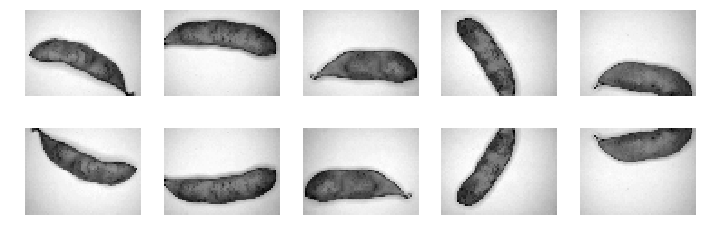

In [5]:
datagen = ImageDataGenerator(
  horizontal_flip=True,
  vertical_flip=True)

g = datagen.flow(X_train, shuffle=False)
draw_sample(g.next(), X_train)

### ２．垂直／水平シフト

上段：元の画像　／　下段：変換後の画像


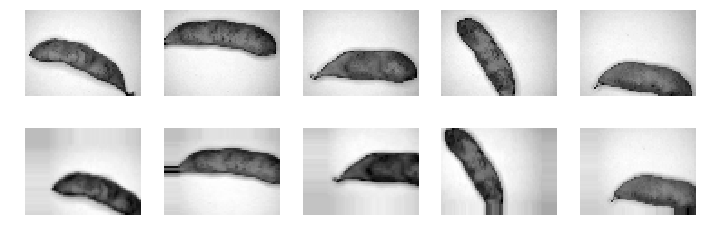

In [6]:
datagen = ImageDataGenerator(
  height_shift_range=0.2,
  width_shift_range=0.2)

g = datagen.flow(X_train, shuffle=False)
draw_sample(g.next(), X_train)

### ３．画像の回転

上段：元の画像　／　下段：変換後の画像


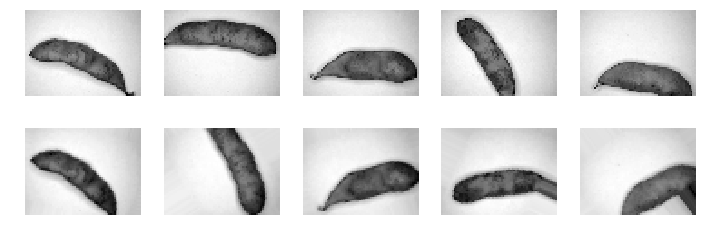

In [7]:
datagen = ImageDataGenerator(
  rotation_range=90)

g = datagen.flow(X_train, shuffle=False)
draw_sample(g.next(), X_train)

### ４．ズーム

上段：元の画像　／　下段：変換後の画像


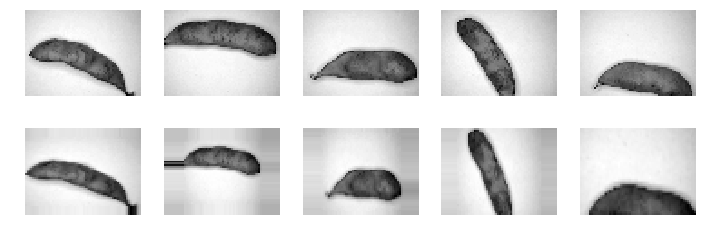

In [8]:
datagen = ImageDataGenerator(
  zoom_range=0.5)

g = datagen.flow(X_train, shuffle=False)
draw_sample(g.next(), X_train)

### ５．チャネルシフト

上段：元の画像　／　下段：変換後の画像


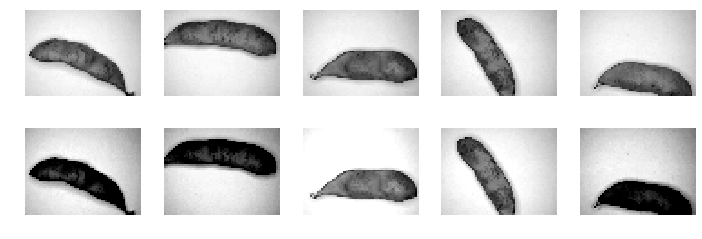

In [9]:
datagen = ImageDataGenerator(
  channel_shift_range=0.6)

g = datagen.flow(X_train, shuffle=False)
draw_sample(g.next(), X_train)

### ６．画像変形（シアー変換）

上段：元の画像　／　下段：変換後の画像


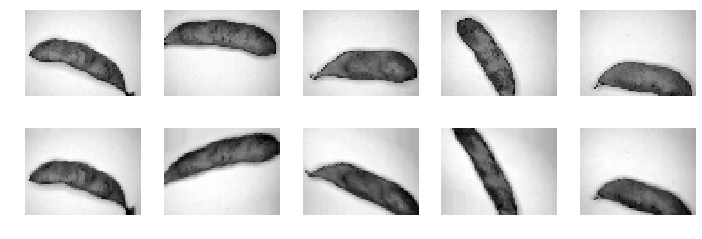

In [10]:
datagen = ImageDataGenerator(
  shear_range=np.pi)

g = datagen.flow(X_train, shuffle=False)
draw_sample(g.next(), X_train)

### ７．Random Crop

上段：元の画像　／　下段：変換後の画像


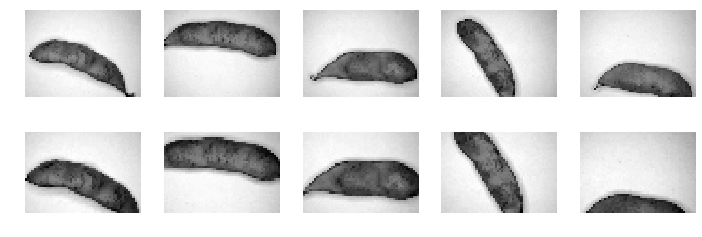

In [11]:
def random_crop(x, size):
  dx = x.shape[2] - size[0]
  dy = x.shape[1] - size[1]
  
  dst = []
  for image in x:
    x = np.random.randint(0, dx)
    y = np.random.randint(0, dy)
    dst.append(image[y:y+size[1],x:x+size[0],:])
  return np.array(dst)
  
cropped = random_crop(X_train, (54, 38))
draw_sample(cropped, X_train)

### ８．Cutout

上段：元の画像　／　下段：変換後の画像


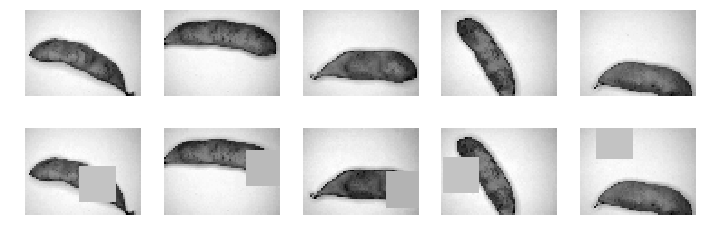

In [12]:
def cutout(image):
  size = image.shape[1] // 3 #マスクサイズは入力画像の1/3
  center_x = np.random.randint(0, image.shape[1])
  center_y = np.random.randint(0, image.shape[0])
  range_w = np.clip((center_x - size//2, center_x + size//2), 0, image.shape[1])
  range_h = np.clip((center_y - size//2, center_y + size//2), 0, image.shape[0])
  image[range_h[0]:range_h[1],range_w[0]:range_w[1],:] = np.mean(image) 
  return image

datagen = ImageDataGenerator(
  preprocessing_function=cutout)

g = datagen.flow(X_train, shuffle=False)
draw_sample(g.next(), X_train)

### ９．Random Erasing

上段：元の画像　／　下段：変換後の画像


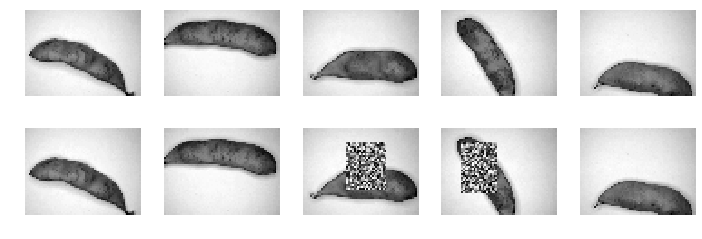

In [13]:
class RandomErasing():
  def __init__(self, p=0.5, sl=0.02, sh=0.4, r1=0.3, r2=3.0):
    self.p = p
    self.sl = sl
    self.sh = sh
    self.r1 = r1
    self.r2 = r2
  
  def transform(self, image):
    if self.p <= np.random.uniform():
      return image
    
    h, w, c = image.shape
    while True:
      se = np.random.uniform(self.sl, self.sh) * (w * h)
      re = np.random.uniform(self.r1, self.r2)
      he = int(np.sqrt(se * re))
      we = int(np.sqrt(se / re))
      
      xe = np.random.randint(0, w)
      ye = np.random.randint(0, h)
      
      if xe + we <= w and ye + he <= h :
        break
        
    image[ye:ye + he, xe:xe + we, :] = np.random.uniform(0, 1.0, size=(he, we, c))
          
    return image
  
datagen = ImageDataGenerator(
  preprocessing_function=RandomErasing().transform)

g = datagen.flow(X_train, shuffle=False)
draw_sample(g.next(), X_train)

### １０．mixup

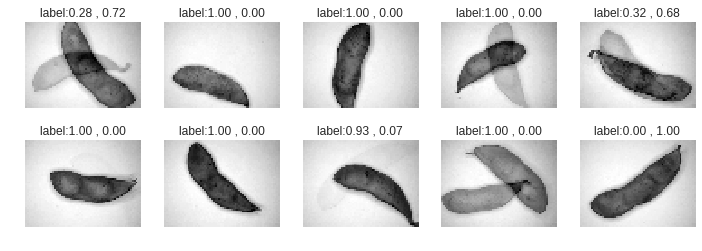

In [59]:
def mixup(images, labels, size=100, alpha=0.2):
  i = np.random.randint(0, images.shape[0], size)
  j = np.random.randint(0, labels.shape[0], size)
  l = np.random.beta(alpha, alpha, size) #Beta分布からsize分のサンプリング

  l_x = l.reshape([size, 1, 1, 1])
  l_y = l.reshape([size, 1])
  
  #size分をランダムに選択
  x_i = images[i]
  y_i = labels[i]
  x_j = images[j]
  y_j = labels[j]
  
  x = x_i * l_x + x_j * (1 - l_x)
  y = y_i * l_y + y_j * (1 - l_y)
  
  return x, y

x, y = mixup(X_train, y_train)
  
fig, ax = plt.subplots(2, 5, figsize=(12, 4))
for i in range(5):
  if IMAGE_CHANNEL == 1:
    ax[0, i].imshow(x[i].reshape(x.shape[1], x.shape[2]), cmap='gray')
    ax[1, i].imshow(x[i+5].reshape(x.shape[1], x.shape[2]), cmap='gray')
  else:
    ax[0, i].imshow(x[i])
    ax[1, i].imshow(x[i+5])
  ax[0, i].axis('off')
  ax[1, i].axis('off')
  ax[0, i].set_title("label:%0.2f , %0.2f"%(y[i][0], y[i][1]))
  ax[1, i].set_title("label:%0.2f , %0.2f"%(y[i+5][0], y[i+5][1]))
plt.show()

# CNNを使った粒数識別器を作る

## モデルの構築

In [0]:
def build_CNN(dropout_rate=0.5, lr=1e-4):
  model_input = Input(shape=[IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL])
  x = Conv2D(32, kernel_size=5, padding='same', kernel_initializer='he_normal')(model_input) #48x64x1->48x64x32
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x) #48x64x32->24x32x32
  x = Conv2D(64, kernel_size=5, padding='same', kernel_initializer='he_normal')(x) #24x32x32->24x32x64
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x) #24x32x64->12x16x64
  x = Conv2D(128, kernel_size=5, padding='same', kernel_initializer='he_normal')(x) #12x16x64->12x16x128
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x) #12x16x128->6x8x128
  x = Flatten()(x) #6x8x128->6*8*128
  x = Dense(256, activation='relu')(x) #6*8*128->256
  x = Dropout(dropout_rate)(x)
  model_output = Dense(CLASSES, activation='softmax')(x) #256->1
  
  model = Model(model_input, model_output)
  model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr), metrics=['acc'])
  return model


## 学習

最初に学習結果を表示するための関数を定義します．

In [0]:
def show_history(fit):
  fig , ax = plt.subplots(1, 2, figsize=(12,6))
  ax[0].plot(fit.history['loss'], label='training loss')
  ax[0].plot(fit.history['val_loss'], label='test loss')
  ax[0].set_title("Loss")
  ax[0].set_xlabel("epochs")
  ax[0].set_ylabel("loss")
  ax[0].legend()
  
  ax[1].plot(fit.history['acc'], label='training acc')
  ax[1].plot(fit.history['val_acc'], label='test acc')
  ax[1].set_title("Accuracy")
  ax[1].set_xlabel("epochs")
  ax[1].set_ylabel("accuracy")
  ax[1].legend()

  plt.show()
  
def show_result(model):
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  y = np.argmax(y_test, axis=1)

  matrix = confusion_matrix(y, y_pred)
  print("混同行列")
  print(matrix)

  miss = X_test[y!=y_pred]

  print("間違えた画像")
  fig, ax = plt.subplots(1, 10, figsize=(12, 4))
  for i in range(10):
    if IMAGE_CHANNEL == 1:
      ax[i].imshow(miss[i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
    else:
      ax[i].imshow(miss[i])
    ax[i].axis('off')
  plt.show()

  print("Best Accuracy:%f"%(max(history.history['val_acc'])))
  print('F1-Score:%f'%(f1_score(y, y_pred)))

### データ拡張なし

In [48]:
cnn0 = build_CNN()

history = cnn0.fit(X_train, y_train,
                  batch_size = 64,
                  epochs = 200,
                  shuffle=True,
                  validation_data = (X_test, y_test))
cnn0.save('cnn0.h5')

Train on 600 samples, validate on 580 samples
Epoch 1/200
600/600 [==============================] - 4s 6ms/step - loss: 1.0407 - acc: 0.5583 - val_loss: 0.7931 - val_acc: 0.5862
Epoch 2/200
600/600 [==============================] - 1s 972us/step - loss: 0.7845 - acc: 0.6283 - val_loss: 0.5122 - val_acc: 0.7483
Epoch 3/200
600/600 [==============================] - 1s 937us/step - loss: 0.5131 - acc: 0.7517 - val_loss: 0.5205 - val_acc: 0.7379
Epoch 4/200
600/600 [==============================] - 1s 936us/step - loss: 0.4400 - acc: 0.7900 - val_loss: 0.4944 - val_acc: 0.7534
Epoch 5/200
600/600 [==============================] - 1s 940us/step - loss: 0.3938 - acc: 0.8350 - val_loss: 0.4644 - val_acc: 0.7776
Epoch 6/200
600/600 [==============================] - 1s 930us/step - loss: 0.3426 - acc: 0.8567 - val_loss: 0.4007 - val_acc: 0.8172
Epoch 7/200
600/600 [==============================] - 1s 896us/step - loss: 0.3111 - acc: 0.8700 - val_loss: 0.3989 - val_acc: 0.7983
Epoch 8/200

#### 結果

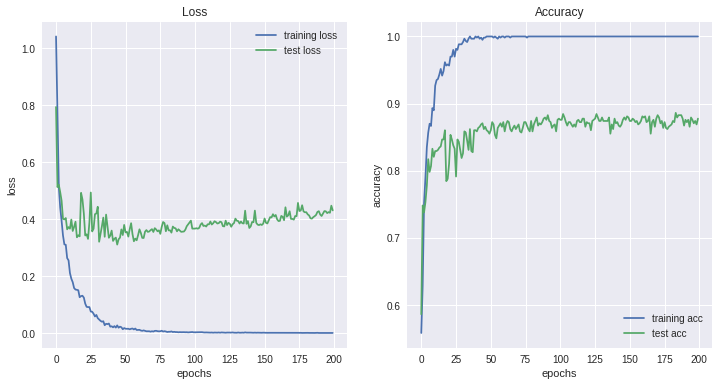

混同行列
[[252  38]
 [ 33 257]]
間違えた画像


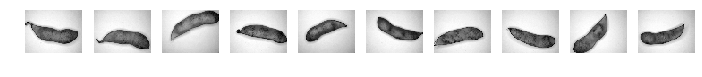

Best Accuracy:0.886207
F1-Score:0.878632


In [49]:
#学習結果の表示
show_history(history)

#間違えたデータを表示
show_result(cnn0)


### 反転と回転によるデータ拡張

In [56]:
cnn1 = build_CNN()
datagen = ImageDataGenerator(rotation_range=60,
                             horizontal_flip=True,
                             vertical_flip=True)

x_aug, y_aug = datagen.flow(X_train, y_train, batch_size=1200).next()

x = np.concatenate([x_aug, X_train])
y = np.concatenate([y_aug, y_train])
history = cnn1.fit(x, y,
                  batch_size = 64,
                  epochs = 200,
                  shuffle=True,
                  validation_data = (X_test, y_test))

cnn1.save("cnn1.h5")

Train on 1200 samples, validate on 580 samples
Epoch 1/200
1200/1200 [==============================] - 5s 4ms/step - loss: 1.1214 - acc: 0.5550 - val_loss: 0.5048 - val_acc: 0.7724
Epoch 2/200
1200/1200 [==============================] - 1s 765us/step - loss: 0.6212 - acc: 0.6717 - val_loss: 0.4647 - val_acc: 0.7845
Epoch 3/200
1200/1200 [==============================] - 1s 760us/step - loss: 0.5017 - acc: 0.7550 - val_loss: 0.4043 - val_acc: 0.8224
Epoch 4/200
1200/1200 [==============================] - 1s 770us/step - loss: 0.4331 - acc: 0.8017 - val_loss: 0.3767 - val_acc: 0.8500
Epoch 5/200
1200/1200 [==============================] - 1s 757us/step - loss: 0.4024 - acc: 0.8142 - val_loss: 0.3584 - val_acc: 0.8517
Epoch 6/200
1200/1200 [==============================] - 1s 765us/step - loss: 0.3428 - acc: 0.8467 - val_loss: 0.3213 - val_acc: 0.8603
Epoch 7/200
1200/1200 [==============================] - 1s 761us/step - loss: 0.3282 - acc: 0.8608 - val_loss: 0.3115 - val_acc: 0.8

#### 結果

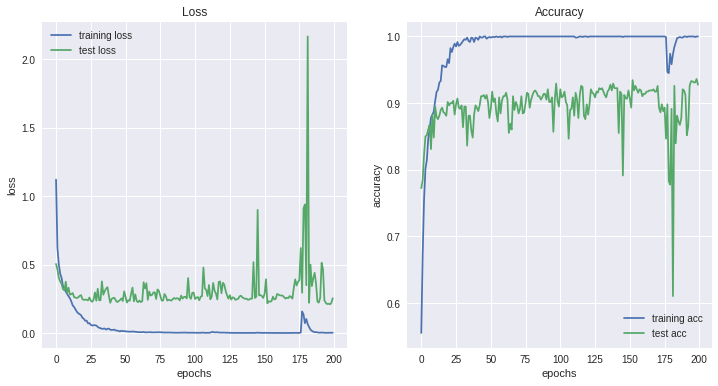

混同行列
[[282   8]
 [ 34 256]]
間違えた画像


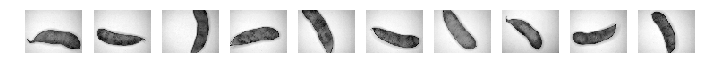

Best Accuracy:0.936207
F1-Score:0.924188


In [57]:
#学習結果の表示
show_history(history)

#間違えたデータを表示
show_result(cnn1)

### mixupの場合

In [68]:
cnn_mixup = build_CNN()

x_aug, y_aug = mixup(X_train, y_train, size=1200)

x = np.concatenate([x_aug, X_train])
y = np.concatenate([y_aug, y_train])
history = cnn_mixup.fit(x, y,
                        shuffle=True,
                        epochs = 200,
                        validation_data = (X_test, y_test))

cnn_mixup.save("cnn_mixup.h5")

Train on 1800 samples, validate on 580 samples
Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.6801 - acc: 0.6778 - val_loss: 0.4558 - val_acc: 0.7707
Epoch 2/200
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4263 - acc: 0.8094 - val_loss: 0.4055 - val_acc: 0.8069
Epoch 3/200
1800/1800 [==============================] - 2s 1ms/step - loss: 0.3234 - acc: 0.8894 - val_loss: 0.4392 - val_acc: 0.7862
Epoch 4/200
1800/1800 [==============================] - 2s 1ms/step - loss: 0.2776 - acc: 0.9050 - val_loss: 0.3857 - val_acc: 0.8172
Epoch 5/200
1800/1800 [==============================] - 2s 1ms/step - loss: 0.2452 - acc: 0.9183 - val_loss: 0.3083 - val_acc: 0.8672
Epoch 6/200
1800/1800 [==============================] - 2s 1ms/step - loss: 0.1962 - acc: 0.9511 - val_loss: 0.3587 - val_acc: 0.8397
Epoch 7/200
1800/1800 [==============================] - 2s 1ms/step - loss: 0.1909 - acc: 0.9567 - val_loss: 0.3278 - val_acc: 0.8448
Epoch 8/

#### 結果

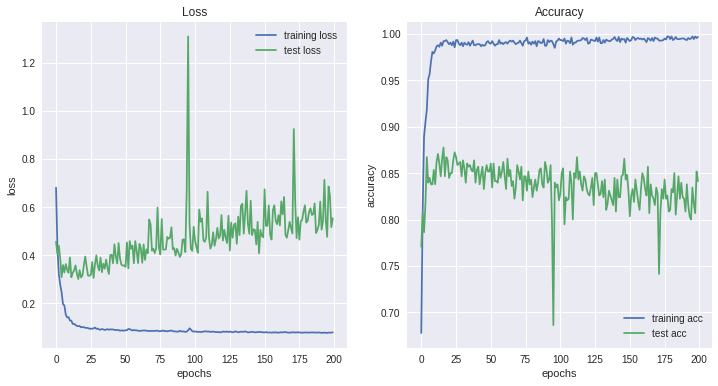

混同行列
[[235  55]
 [ 37 253]]
間違えた画像


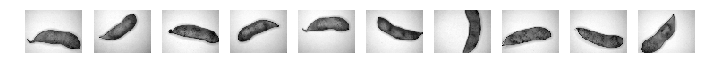

Best Accuracy:0.877586
F1-Score:0.846154


In [69]:
#学習結果の表示
show_history(history)

#間違えたデータを表示
show_result(cnn_mixup)

### GANによるデータ拡張
GANを使ってデータ拡張を行います．Generatorで生成した画像をDiscrimitorで選別して，Discrimitorが本物画像と判断した画像を学習データとして使用します．

In [14]:
#GANを使って仮想データを作る

def create_gan_images(num=5000):
  for i in range(CLASSES):
    cond = np.tile(np.eye(CLASSES)[i], (num,1))
    noize = np.random.uniform(0, 1, size=[num, 100])
    generated_images = generator.predict([noize, cond])
    if i == 0:
      x_gan = generator.predict([noize, cond])
      y_gan = cond
    else:
      x_gan = np.concatenate([x_gan, generated_images])
      y_gan = np.concatenate([y_gan, cond])

  print("generatorが%d枚の画像を生成"%(x_gan.shape[0]))
  return x_gan, y_gan

X_train_gan, y_train_gan = create_gan_images()
print(X_train_gan.shape, y_train_gan.shape)



generatorが10000枚の画像を生成
(10000, 48, 64, 1) (10000, 2)


Discriminatorが本物と判断した枚数：3542
各ラベルから同数取得できる枚数：1687
※この中から各ラベル300枚を使用する
最終的にデータ拡張に使用する生成画像の枚数：600


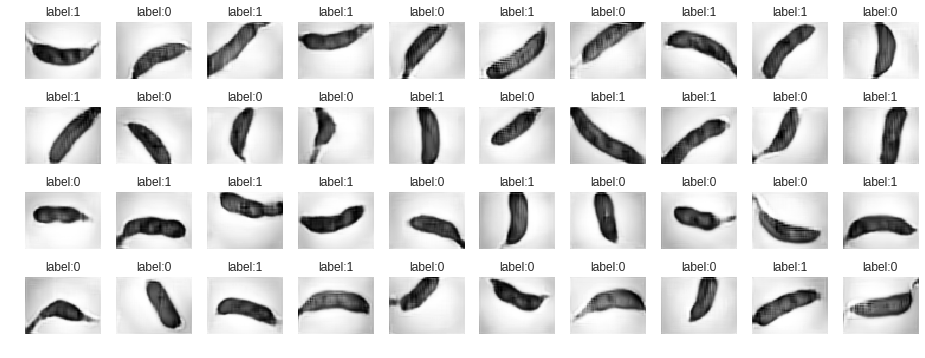

In [15]:

#画像の選別
def select_elaborate(images, labels, disc_model, cnn_model=None, max_num=300):
  #discriminatorで本物と判断したものを選別
  y_ = disc_model.predict([images, labels])
  y_ = y_.argmax(axis=-1)

  x_selected = images[y_==1]
  y_selected = labels[y_==1]
  print("Discriminatorが本物と判断した枚数：%d"%(x_selected.shape[0]))

  if cnn_model is not None:
    #認識精度が高いものを選別
    y_ = cnn_model.predict(x_selected)
    y_ = y_.argmax(axis=-1)
    y_true = y_selected.argmax(axis=-1)

    matrix = confusion_matrix(y_true, y_)
    print("混同行列")
    print(matrix)
  
    valid_num = min([matrix[0][0], matrix[1][1]])

    x_correct = x_selected[y_true==y_]
    y_correct = y_selected[y_true==y_]
    x_selected = x_correct[y_correct.max(axis=-1) > 0.9]
    y_selected = y_correct[y_correct.max(axis=-1) > 0.9]

    print("認識精度が0.9を超えた枚数：%d"%(x_selected.shape[0]))

  #ラベル毎に同数だけ取り出す
  y_true = y_selected.argmax(axis=-1)
  valid_num = min(y_true[y_true==0].shape[0], y_true[y_true==1].shape[0])
  print("各ラベルから同数取得できる枚数：%d"%(valid_num))
  print("※この中から各ラベル%d枚を使用する"%(max_num))

  #データ拡張に使用する枚数は各ラベルmax_num枚とする
  valid_num = max_num if valid_num > max_num else valid_num
  x_selected_0 = x_selected[y_true==0][:valid_num]
  y_selected_0 = y_selected[y_true==0][:valid_num]
  x_selected_1 = x_selected[y_true==1][:valid_num]
  y_selected_1 = y_selected[y_true==1][:valid_num]

  x_selected = np.concatenate([x_selected_0, x_selected_1])
  y_selected = np.concatenate([y_selected_0, y_selected_1])
  print("最終的にデータ拡張に使用する生成画像の枚数：%d"%(x_selected.shape[0]))

  r_index = np.random.permutation(np.arange(x_selected.shape[0]))
  x_selected = x_selected[r_index]
  y_selected = y_selected[r_index]
  
  return x_selected, y_selected

X_train_gan_selected, y_train_gan_selected = select_elaborate(X_train_gan, y_train_gan, discriminator, max_num=300)

#画像の確認
fig, ax = plt.subplots(4, 10, figsize=(16, 6))
for i in range(4):
  for j in range(10):
    if IMAGE_CHANNEL == 1:
        ax[i, j].imshow(X_train_gan_selected[i*10+j].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
    else:
        ax[i, j].imshow(X_train_gan_selected[i*10+j])
    ax[i, j].set_title("label:%d"%(np.argmax(y_train_gan_selected[i*10+j])))
    ax[i, j].axis('off')

plt.show()

In [76]:
#学習
cnn_gan0 = build_CNN()

X_train_gan, y_train_gan = create_gan_images(num=10000)
X_train_gan_selected, y_train_gan_selected = select_elaborate(X_train_gan, y_train_gan, discriminator, max_num=600)

x = np.concatenate([X_train_gan_selected, X_train])
y = np.concatenate([y_train_gan_selected, y_train])
history = cnn_gan0.fit(x, y,
                  batch_size = 64,
                  epochs = 200,
                  shuffle=True,
                  validation_data = (X_test, y_test))

cnn_gan0.save("cnn_gan0.h5")

generatorが20000枚の画像を生成
Discriminatorが本物と判断した枚数：7007
各ラベルから同数取得できる枚数：3334
※この中から各ラベル600枚を使用する
最終的にデータ拡張に使用する生成画像の枚数：1200
Train on 1800 samples, validate on 580 samples
Epoch 1/200
1800/1800 [==============================] - 6s 4ms/step - loss: 0.7657 - acc: 0.6350 - val_loss: 0.4957 - val_acc: 0.7586
Epoch 2/200
1800/1800 [==============================] - 1s 741us/step - loss: 0.4886 - acc: 0.7606 - val_loss: 0.4183 - val_acc: 0.8086
Epoch 3/200
1800/1800 [==============================] - 1s 740us/step - loss: 0.4092 - acc: 0.8161 - val_loss: 0.4800 - val_acc: 0.7776
Epoch 4/200
1800/1800 [==============================] - 1s 733us/step - loss: 0.3426 - acc: 0.8550 - val_loss: 0.3277 - val_acc: 0.8586
Epoch 5/200
1800/1800 [==============================] - 1s 735us/step - loss: 0.3026 - acc: 0.8639 - val_loss: 0.3341 - val_acc: 0.8466
Epoch 6/200
1800/1800 [==============================] - 1s 740us/step - loss: 0.2650 - acc: 0.8894 - val_loss: 0.2949 - val_acc: 0.8793
Epoch 7/200
1

#### 結果

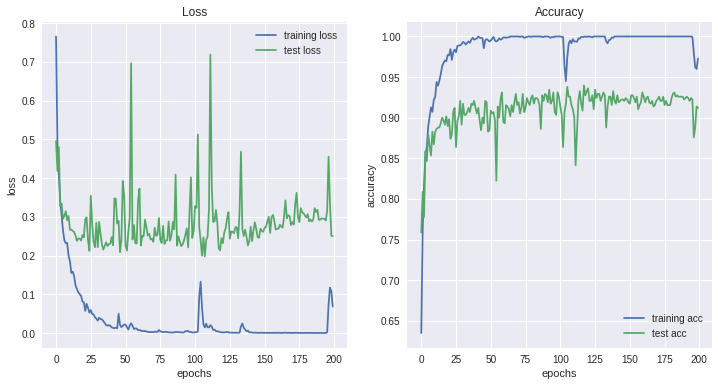

混同行列
[[266  24]
 [ 27 263]]
間違えた画像


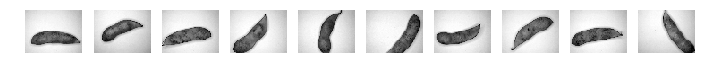

Best Accuracy:0.939655
F1-Score:0.911612


In [77]:
show_history(history)

#間違えたデータを表示
show_result(cnn_gan0)

### 反転と回転＋GANによるデータ拡張

In [86]:
#学習
cnn_gan1 = build_CNN()

X_train_gan, y_train_gan = create_gan_images(num=10000)
X_train_gan_selected, y_train_gan_selected = select_elaborate(X_train_gan, y_train_gan, discriminator, max_num=300)

x_ = np.concatenate([X_train_gan_selected, X_train])
y_ = np.concatenate([y_train_gan_selected, y_train])

datagen = ImageDataGenerator(rotation_range=60,
                             horizontal_flip=True,
                             vertical_flip=True)

x_aug, y_aug = datagen.flow(x_, y_, batch_size=1200).next()

x = np.concatenate([x_aug, X_train])
y = np.concatenate([y_aug, y_train])
history = cnn_gan1.fit(x, y,
                  batch_size = 64,
                  epochs = 200,
                  shuffle=True,
                  validation_data = (X_test, y_test))

cnn_gan1.save("cnn_gan1.h5")

generatorが20000枚の画像を生成
Discriminatorが本物と判断した枚数：6966
各ラベルから同数取得できる枚数：3244
※この中から各ラベル300枚を使用する
最終的にデータ拡張に使用する生成画像の枚数：600
Train on 1800 samples, validate on 580 samples
Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.8808 - acc: 0.5939 - val_loss: 0.4670 - val_acc: 0.7914
Epoch 2/200
1800/1800 [==============================] - 1s 725us/step - loss: 0.5233 - acc: 0.7394 - val_loss: 0.4422 - val_acc: 0.8017
Epoch 3/200
1800/1800 [==============================] - 1s 730us/step - loss: 0.4381 - acc: 0.7933 - val_loss: 0.4146 - val_acc: 0.7983
Epoch 4/200
1800/1800 [==============================] - 1s 729us/step - loss: 0.4073 - acc: 0.8133 - val_loss: 0.3470 - val_acc: 0.8414
Epoch 5/200
1800/1800 [==============================] - 1s 729us/step - loss: 0.3772 - acc: 0.8433 - val_loss: 0.3701 - val_acc: 0.8397
Epoch 6/200
1800/1800 [==============================] - 1s 728us/step - loss: 0.3473 - acc: 0.8467 - val_loss: 0.3072 - val_acc: 0.8586
Epoch 7/200
18

#### 結果

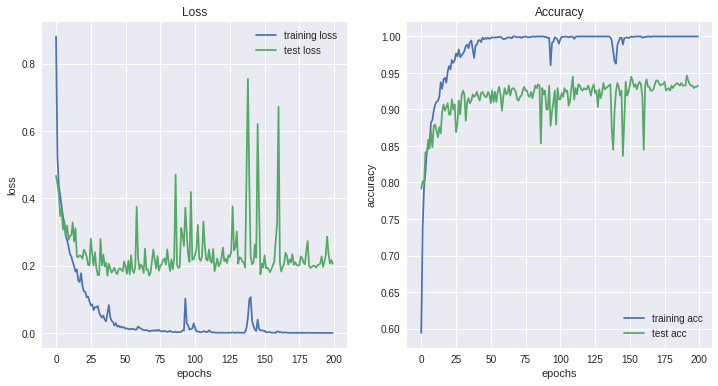

混同行列
[[269  21]
 [ 18 272]]
間違えた画像


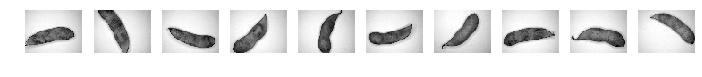

Best Accuracy:0.946552
F1-Score:0.933105


In [88]:
show_history(history)

#間違えたデータを表示
show_result(cnn_gan1)

# 学習済みモデルのダウンロード

In [89]:
import os
from google.colab import files

!ls
files.download('generator.h5')
files.download('combined_model.h5')
files.download('discrimitor.h5')
files.download('cnn0.h5')
files.download('cnn1.h5')
files.download('cnn_mixup.h5')
files.download('cnn_gan0.h5')
files.download('cnn_gan1.h5')


cnn0.h5      cnn_gan1.h5	discrimitor.h5	soybeans_dataset.npz
cnn1.h5      cnn_mixup.h5	generator.h5	wget-log
cnn_gan0.h5  combined_model.h5	sample_data
